## Import the necessary libraries

In [2]:
# Import the necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import scipy
from scipy.io import loadmat, savemat
from utils.data_utils import generate_trajectory_fixed_variances_pairs, generate_trajectory_modified_variances_pairs
from utils.plot_utils import plot_trajectories
import json
from src.rnn_models_NLSS_modified import RNN_model, push_model

In [3]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [4]:
with open('./log/estimate_theta_vars/gru_L2_H30_modified_RNN/gru_losses_eps2000_vars.json') as p:
    plot_data_gru = json.load(p)

with open('./log/estimate_theta_vars/gru_L2_H30_modified_RNN/gru_losses_eps3000_vars_2.json') as p:
    plot_data_gru_3000 = json.load(p)

with open('./log/estimate_theta_vars/lstm_L1_H60_modified_RNN/lstm_losses_eps3000_vars_2.json') as p:
    plot_data_lstm = json.load(p)

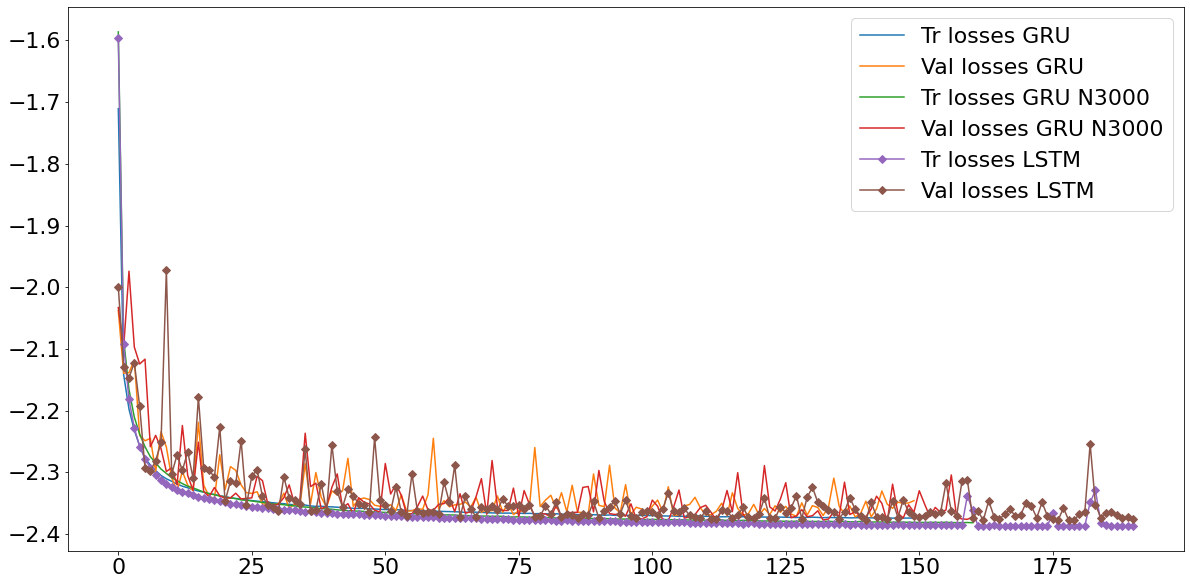

In [5]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot(np.log10(plot_data_gru['tr_losses']))
plt.plot(np.log10(plot_data_gru['val_losses']))
plt.plot(np.log10(plot_data_gru_3000['tr_losses']))
plt.plot(np.log10(plot_data_gru_3000['val_losses']))
plt.plot(np.log10(plot_data_lstm['tr_losses']), 'D-')
plt.plot(np.log10(plot_data_lstm['val_losses']), 'D-')
plt.legend(['Tr losses GRU', 'Val losses GRU', 'Tr losses GRU N3000', 'Val losses GRU N3000', 'Tr losses LSTM', 'Val losses LSTM'])
plt.show()

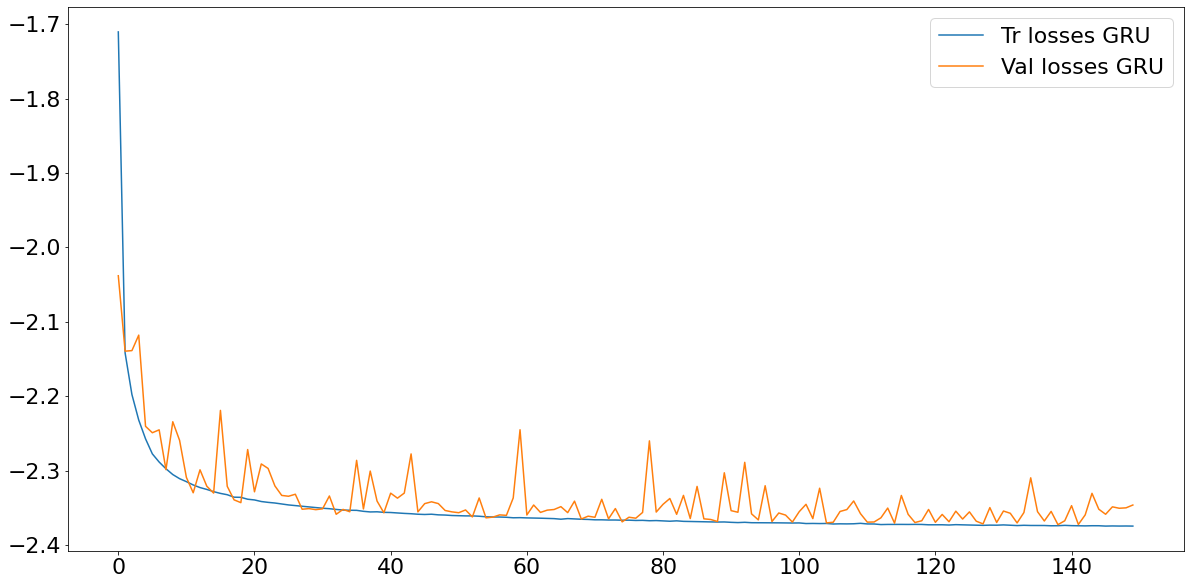

In [6]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot(np.log10(plot_data_gru['tr_losses']))
plt.plot(np.log10(plot_data_gru['val_losses']))
plt.legend(['Tr losses GRU', 'Val losses GRU'])
plt.show()

In [7]:
# Set parameters for training data generation
N=200
M=100
P=1

In [8]:
# Load the dataset
Z_pM_test_sampled_theta = generate_trajectory_modified_variances_pairs(N, M=1, P=100, usenorm_flag=0)
#Z_pM_test_sampled_theta = loadmat('evaluation_data/variances/evaluation_DN_1000_N_200_samples_var.mat')

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
# Saving the created datasets
#savemat('./evaluation_data/variances/evaluation_ZN_{}_N_{}_fixed_samples_var_2.mat'.format(M*P, N), Z_pM_test_sampled_theta)

In [10]:
#Z_pM_test_fixed_theta = generate_trajectory_fixed_variances_pairs(N=N, M=100, P=1, usenorm_flag=0)
Z_pM_test_fixed_theta = loadmat('evaluation_data/variances/evaluation_ZN_100_fixed_samples_latest.mat')

In [11]:
#savemat('evaluation_data/variances/evaluation_ZN_{}_fixed_samples_latest.mat'.format(M*P), Z_pM_test_fixed_theta)

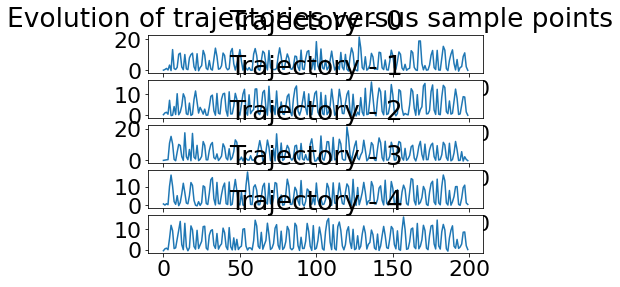

In [12]:
plot_trajectories(Z_pM=Z_pM_test_fixed_theta, nrows=int(5), ncols=1)

In [13]:
# Importing the model configuration options
with open("./config/configurations_vars.json") as f:
    options = json.load(f)

### Load results from MATLAB model

In [14]:
res_matlab_method = loadmat('matlab_results/results_ML_sampled_theta_pMCMC_MP100_latest_tuned_indices.mat')

In [15]:
mse_vec = res_matlab_method['res_MC_theta_fixed']['msevec'][-1][-1]
preds_vector = res_matlab_method['res_MC_theta_fixed']['preds_vector'][-1][-1]
default_mask = np.array([True]*int(M*P))
#default_mask = np.concatenate((np.array([True]*int(M*P)), np.array([False]*int(1000 - M*P))))
#default_mask[3] = False
#default_mask[63] = False

In [16]:
def get_chosen_idx(num_datasets=10, M=100, P=1):
    idx_chosen = np.random.choice(a=int(M*P), size=(num_datasets,), replace=False)
    print(idx_chosen)
    return idx_chosen

In [17]:
_ = get_chosen_idx(num_datasets=10, M=100, P=1)

[96  5 74 66 28 99 21 53 65 60]


In [18]:
len(default_mask)

100

In [19]:
default_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Analysis for GRU model

In [20]:
# Prediction using trained model
def compute_loss_using_saved_model(actual_data, actual_theta_vectors, best_saved_model, model_type, device, criterion=None, mask=None):
    te_running_loss = 0.0
    test_loss_epoch_sum = 0.0
    mask = mask.flatten()
    #mask = [True, True, False, False, True, True, True]
    with torch.no_grad():

        X_test = Variable(torch.from_numpy(actual_data), requires_grad=False).type(torch.FloatTensor).to("cpu")
        prediction_theta_vectors = best_saved_model.forward(X_test)
        print(prediction_theta_vectors[:10, :])
        prediction_theta_vectors = torch.cat((prediction_theta_vectors[:, :-2], 
                                              torch.square(prediction_theta_vectors[:, -2:])), dim=1)
        
        loss = criterion(prediction_theta_vectors[mask, :], torch.from_numpy(actual_theta_vectors.squeeze(2)[mask, :]))
        print("Loss for saved {} model is : {}".format(model_type, loss))
        print("-"*100)
    
    return loss, prediction_theta_vectors

In [21]:
# Define a function for loading model
def load_model_from_weights(model_type, model_file, device):
    #Load and Set model in evaluation mode
    model = RNN_model(**options[model_type]).to(device)
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    model = push_model(nets=model, device=device)
    model.eval()
    return model

In [22]:
np.set_printoptions(suppress=True)

In [26]:
def evaluate_using_saved_RNN_model(Z_pM_test, best_saved_model_file, model_type='gru', device='cpu', criterion=None, mask=None, sampled=False, savefig=None):
    
    # Define some criterion for evaluation if not specified already
    if criterion is None:
        criterion = nn.MSELoss(reduction='mean')
    
    # Load the saved model
    best_saved_model = load_model_from_weights(model_type, 
                                               best_saved_model_file, 
                                               device)
    
    # Print some shapes for sanity check
    # Print out some shapes for sanity check
    print(Z_pM_test_sampled_theta["data"][0][1].shape, 
          type(Z_pM_test_sampled_theta["data"][0][1]), 
          Z_pM_test_sampled_theta["data"][0][0].shape)
    
    # Get the data and targets separately as a numpy array
    actual_data = np.row_stack([np.expand_dims(Z_pM_test["data"][i][1], axis=0) for i in range(len(Z_pM_test["data"]))])
    actual_theta_vectors = np.row_stack([np.expand_dims(Z_pM_test["data"][i][0], axis=0) for i in range(len(Z_pM_test["data"]))])
    
    # Print shape of inputs and targets
    print("Input shape:{}, Targets shape:{}".format(actual_data.shape, actual_theta_vectors.shape))
    
    # Get loss, predictions
    loss, predicted_theta_vectors = compute_loss_using_saved_model(actual_data, 
                                                                   actual_theta_vectors, 
                                                                   best_saved_model, 
                                                                   model_type, 
                                                                   device,
                                                                   criterion,
                                                                   mask=mask)
    print("-"*100)
    print("Mean")
    print(torch.mean(predicted_theta_vectors, axis=0))
    print("-"*100)
    print("Covariance matrix")
    print(np.cov(predicted_theta_vectors.numpy(), rowvar=False))
    #plt.figure(figsize=(20, 10))
    #plt.imshow(np.cov(predicted_theta_vectors.numpy(), rowvar=False), vmin=0, vmax=1, interpolation='nearest')
    #plt.title('Covariance matrix for the 5-parameter results')
    print("-"*100)
    print("Prediction results")
    # Check one of the predictions
    # np.random.choice(100, (10,), replace=False)
    print(np.c_[predicted_theta_vectors[:10, :], actual_theta_vectors.squeeze(2)[:10, :]])
    
    # Prediction boxplots
    plt.rcParams["font.family"] = "serif"
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 5))
    green_diamond = dict(markerfacecolor='r', marker='D')
    meanprops = dict(linewidth=3.0, color='green', linestyle='solid')
    medianprops = dict(linewidth=4.0, color='orange', linestyle='solid')
    
    if sampled == False:
        # theta_6

        plt.subplot(121)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), showmeans=True, flierprops=green_diamond, notch=False,
                                                meanline=True, meanprops=meanprops, medianprops=medianprops)
        plt.grid(True)
        plt.xticks([1], [''])
        plt.title(r'$\theta_7$')
        #plt.axhline(actual_theta_vectors[0, 0], c='b')
        #plt.xticks(np.arange(0.3, 0.7, 5), str(np.arange(0.3, 0.7, 5)))

        # theta_7
        plt.subplot(122)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), showmeans=True, flierprops=green_diamond, notch=False,
                                                meanline=True, meanprops=meanprops, medianprops=medianprops)
        plt.xticks([1], [''])
        plt.title(r'$\theta_8$')
        plt.grid(True)
        #plt.axhline(actual_theta_vectors[0, 1], c='b')
        
    else:
        # theta_6
        plt.subplot(121)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), sym='r+', showmeans=True, meanline=True)
        #plt.axhline(np.mean(actual_theta_vectors, axis=0)[0], c='b')

        # theta_7
        plt.subplot(122)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), sym='r+', showmeans=True, meanline=True)
        #plt.axhline(np.mean(actual_theta_vectors, axis=0)[1], c='b')
    
    if not savefig is None:
        plt.savefig(savefig)
    return loss, predicted_theta_vectors

### Evaluating the results for GRU model

Baseline MSE using MATLAB 0.007741573611799746
Evaluate for model:models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0416, 0.3773],
        [1.0280, 0.3377],
        [1.0595, 0.4220],
        [0.8510, 0.3691],
        [0.8939, 0.2641],
        [1.0465, 0.2994],
        [0.9116, 0.3481],
        [1.0042, 0.3406],
        [1.0867, 0.3188],
        [1.0885, 0.3392]])
Loss for saved gru model is : 0.011863441147208418
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([1.0304, 0.1024])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[ 0.02220669 -0.00038028]
 [-0.00038028  0.00082059]]
---------------------------------------------------

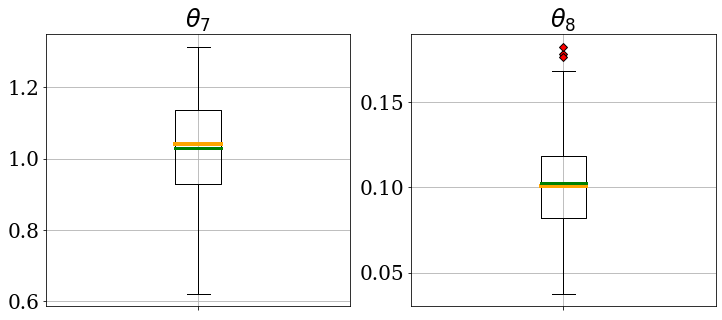

In [27]:
best_model_gru_model_vars = 'models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt'
print("Baseline MSE using MATLAB {}".format(np.mean(mse_vec[default_mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars))
gru_best_model_loss_vars, gru_best_model_predicted_theta_vectors_vars = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

## For P=2000, M=500

Baseline MSE using MATLAB 0.007741573611799746
Evaluate for model:models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0212, 0.3288],
        [1.0103, 0.3257],
        [1.0684, 0.3763],
        [0.8825, 0.3187],
        [0.8674, 0.2369],
        [1.0281, 0.3324],
        [0.9031, 0.3335],
        [1.0078, 0.3556],
        [1.0041, 0.3371],
        [1.0266, 0.3039]])
Loss for saved gru model is : 0.00857754625936935
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([0.9757, 0.0979])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[0.01629125 0.00004949]
 [0.00004949 0.00043757]]
----------------------------------------

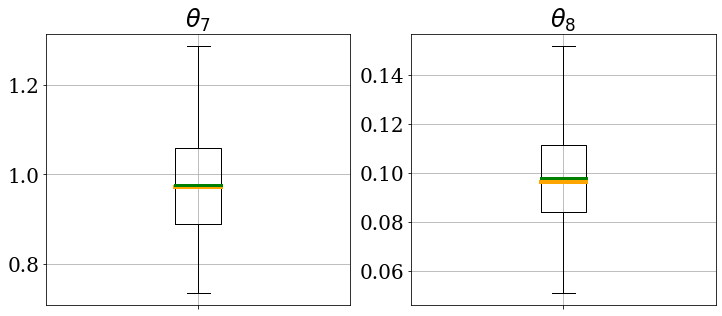

In [28]:
best_model_gru_model_vars_P2000_M500 = 'models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt'  
print("Baseline MSE using MATLAB {}".format(np.mean(mse_vec[default_mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars_P2000_M500))
gru_best_model_loss_vars_P2000_M500, gru_best_model_predicted_theta_vectors_vars_P2000_M500 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars_P2000_M500,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask,
                                                                                             savefig='./result_figures/boxplot_variances_M500_P2000_withgrid.pdf')

### Compare MATLAB and Python results over 10 randomly chosen datasets

In [136]:
idx_chosen = get_chosen_idx(num_datasets=10, M=100, P=1)
print(np.c_[idx_chosen.reshape((-1, 1)), np.square(preds_vector[idx_chosen, :]), gru_best_model_predicted_theta_vectors_vars_P2000_M500[idx_chosen, :]]) 

[22 87 27 63 65 92 83 25 26 82]
[[22.          0.97934969  0.14152961  0.91461778  0.13323258]
 [87.          1.17119319  0.09387522  1.0954361   0.08799669]
 [27.          1.103461    0.08423921  1.0397799   0.08553965]
 [63.          0.92506547  0.07919506  0.85323936  0.06214847]
 [65.          1.09461703  0.10667917  1.0376066   0.07798141]
 [92.          0.98270949  0.11315296  0.91342956  0.11302278]
 [83.          1.00226678  0.12716261  0.9979496   0.13643192]
 [25.          0.87461673  0.08944556  1.00601292  0.08684463]
 [26.          1.13883558  0.09816558  1.15532112  0.06622624]
 [82.          0.87609986  0.10400386  0.84092373  0.09640083]]


Baseline MSE using MATLAB 0.007741573611799746
Evaluate for model:models/gru_L2_H30_modified_RNN_var_M1000_P1000_N200/gru_usenorm_0_ckpt_epoch_161_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0695, 0.3397],
        [1.0429, 0.3260],
        [1.1201, 0.3980],
        [0.9278, 0.3273],
        [0.9242, 0.2542],
        [1.0503, 0.3424],
        [0.9455, 0.3394],
        [1.0301, 0.3503],
        [1.0408, 0.3366],
        [1.0541, 0.3260]])
Loss for saved gru model is : 0.010051898813144307
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([1.0667, 0.1007])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[0.01538287 0.00007713]
 [0.00007713 0.00042629]]
--------------------------------------

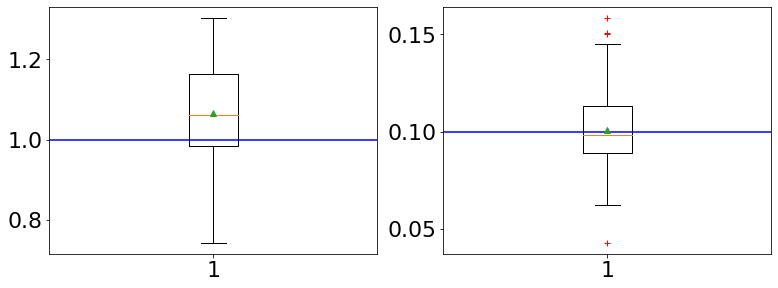

In [39]:
best_model_gru_model_vars_P1000_M1000 = 'models/gru_L2_H30_modified_RNN_var_M1000_P1000_N200/gru_usenorm_0_ckpt_epoch_161_best.pt'  
print("Baseline MSE using MATLAB {}".format(np.mean(mse_vec[default_mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars_P1000_M1000))
gru_best_model_loss_vars_P2000_M500, gru_best_model_predicted_theta_vectors_vars_P1000_M1000 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars_P1000_M1000,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

Baseline MSE using MATLAB 0.8486210996604711
Evaluate for model:models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.1123, 0.8607],
        [0.4913, 0.9305],
        [0.9988, 0.7290],
        [0.6071, 0.6456],
        [0.9121, 0.5523],
        [0.8862, 0.3692],
        [0.3966, 0.9083],
        [1.0913, 0.8321],
        [0.5806, 0.6970],
        [0.6177, 0.4174]])
Loss for saved gru model is : 0.016456757086580752
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7504, 0.4750])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[ 0.1313269  -0.02432428]
 [-0.02432428  0.0829085 ]]
-------------------------------------

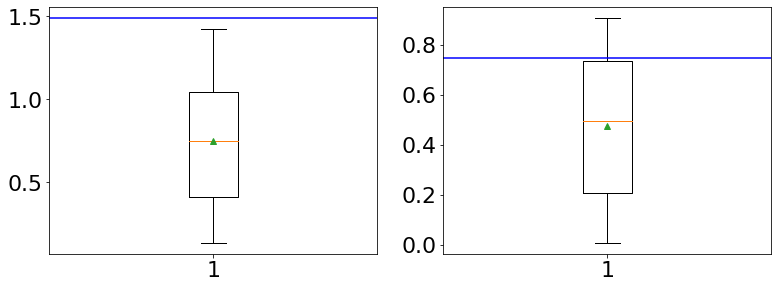

In [24]:
best_model_gru_model_vars_P2000_M500_s = 'models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt'  
print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars_P2000_M500))
gru_best_model_loss_vars_P2000_M500_s, gru_best_model_predicted_theta_vectors_vars_P2000_M500_s = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_sampled_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars_P2000_M500,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

## Evaluation of the model on sampled theta

Baseline MSE using MATLAB 0.8486210996604711
Evaluate for model:models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt
Evaluate for model:models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.1121, 0.8686],
        [0.4704, 0.9214],
        [1.0049, 0.7258],
        [0.6009, 0.6602],
        [0.8874, 0.5505],
        [0.9163, 0.3582],
        [0.4885, 0.8690],
        [1.0735, 0.8829],
        [0.5353, 0.7048],
        [0.5957, 0.4229]])
Loss for saved gru model is : 0.021108869367751318
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([0.7677, 0.4924])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[ 0.12903099 -0.

'\nprint("Evaluate for model:{}".format(trained_gru_model))\ngru_model_loss_fixed, gru_model_predicted_theta_vectors_fixed = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,\n                                                                                 best_saved_model_file=trained_gru_model,\n                                                                                 model_type=\'gru\',\n                                                                                 device=\'cpu\',\n                                                                                 criterion=nn.MSELoss(reduction=\'mean\'),\n                                                                                 mask=default_mask)\n'

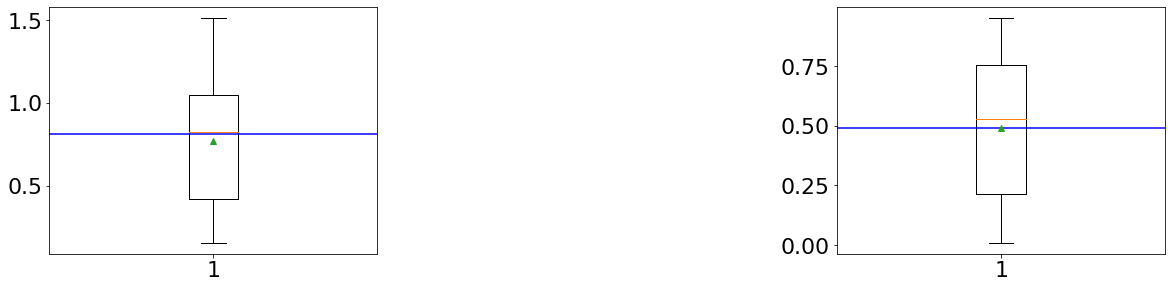

In [25]:
best_model_gru_model = 'models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt'
print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model))

#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_gru_model))
gru_best_model_loss_sampled, gru_best_model_predicted_theta_vectors_sampled = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_sampled_theta,
                                                                                             best_saved_model_file=best_model_gru_model,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask,
                                                                                             sampled=True)

#print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
'''
print("Evaluate for model:{}".format(trained_gru_model))
gru_model_loss_fixed, gru_model_predicted_theta_vectors_fixed = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                 best_saved_model_file=trained_gru_model,
                                                                                 model_type='gru',
                                                                                 device='cpu',
                                                                                 criterion=nn.MSELoss(reduction='mean'),
                                                                                 mask=default_mask)
'''

### Evaluating the results for LSTM model

Baseline MSE using MATLAB 0.8486210996604711
Evaluate for model:models/lstm_L1_H60_modified_RNN/lstm_usenorm_0_ckpt_epoch_191_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0883, 0.3348],
        [1.0556, 0.3326],
        [1.0945, 0.3977],
        [0.9620, 0.2954],
        [0.9197, 0.2409],
        [1.0562, 0.3531],
        [0.9333, 0.3268],
        [1.0347, 0.3650],
        [1.0455, 0.3536],
        [1.0539, 0.3206]])
Loss for saved lstm model is : 0.009823128318901383
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([1.0539, 0.1002])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[0.01643282 0.0000651 ]
 [0.0000651  0.00047661]]
----------------------------------------------------------

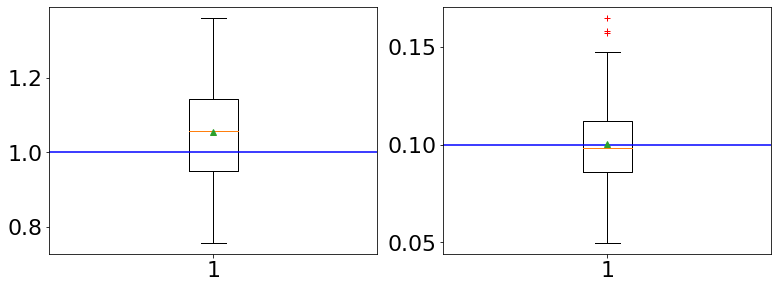

In [27]:
best_model_lstm_model_vars = 'models/lstm_L1_H60_modified_RNN/lstm_usenorm_0_ckpt_epoch_191_best.pt'
print("Baseline MSE using MATLAB {}".format(np.mean(res_matlab_method['res_sampled_theta']['msevec'][-1][-1][mask])))
print("Evaluate for model:{}".format(best_model_lstm_model_vars))
lstm_best_model_loss_vars, lstm_best_model_predicted_theta_vectors_vars = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_lstm_model_vars,
                                                                                             model_type='lstm',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)